In [213]:
import sys
import os
import time
import numpy as np
np.random.seed(42)

import json
import tensorflow as tf

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
#%matplotlib notebook
#%matplotlib inline
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import importlib
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'vae-sld')
src_dir = os.path.join(os.path.expanduser('~'), 'git', 'vae-sld', 'src')
sys.path.append(src_dir)


In [233]:
import rl_model
importlib.reload(rl_model)

import fitting

final_state_expt_file = '/Users/m2d/git/vae-sld/data/time-resolved/cell_b/201290v2-expt.json'
initial_state_expt_file = '/Users/m2d/git/vae-sld/data/time-resolved/cell_b/201282v2-expt.json'
data_file = '/Users/m2d/git/vae-sld/data/time-resolved/cell_b/cell-b-data-60.npy'
timestamps = np.load('/Users/m2d/git/vae-sld/data/time-resolved/cell_b/cell-b-data-60_times.npy')
#ec_cp1 = np.loadtxt(os.path.join(project_dir, 'ec-data', 'Expt6_Summary_CP1.txt'), delimiter=',', skiprows=1).T

_data = np.load(data_file)

REVERSE = False
  
# create an instance of our custom environment
env = rl_model.SLDEnv( initial_state_file=initial_state_expt_file,
                      final_state_file=final_state_expt_file,
                      data=_data, reverse=REVERSE)

# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
from gymnasium.utils.env_checker import check_env
check_env(env)

# initialize the environment
env.reset()
env.render()

print(type(env.action_space))

0
<class 'gymnasium.spaces.box.Box'>


reward: -1.892330913891676
[ 0.41849392 -0.39400794 -0.73777526  0.04711708  0.85771917 -0.65382461
 -0.33765292 -0.82586653 -0.20727959]


<IPython.core.display.Javascript object>


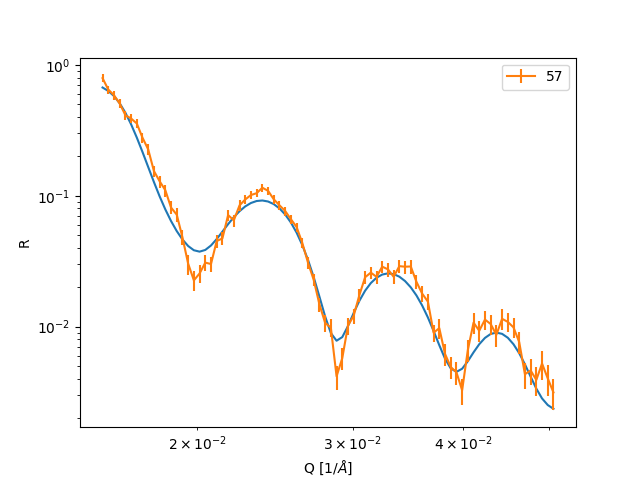

In [224]:
terminated = False

#while not terminated: 
for i in range(1):
    #time.sleep(1)

    # choose a random action
    if False:
        action = env.action_space.sample() 
    else:
        action = env.normalized_parameters

    # take the action and get the information from the environment
    new_state, reward, terminated, truncated, info = env.step(action)
    print("reward: %s" % reward)
    # show the current position and reward
    env.render(action=action, reward=reward) 
    env.plot(errors=True)

In [239]:
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.callbacks import CheckpointCallback

checkpoint_callback = CheckpointCallback(
  save_freq=10000,
  save_path="./logs-forward/",
  name_prefix="rl_model-forward",
  save_replay_buffer=True,
  save_vecnormalize=True,
)

model = SAC('MlpPolicy', env, use_sde=False, verbose=0)

if True:
    model.learn(1000000, callback=checkpoint_callback)
    model.save('cell-b-CV1-60-SAC-forward')
else:
    model = SAC.load("cell-b-CV1-30-SAC")

# Compute uncertainties

In [240]:
deltas = env.high_array - env.low_array

samples = []

for n in range(100):
    actions = []
    obs, info = env.reset()
    for i in range(n_times):
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
    
    actions = np.asarray(actions)
    values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0
    samples.append(values)


samples = np.asarray(samples).T
print(samples.shape)

errs = np.std(samples, axis=2)
print(errs.shape)

(8, 59, 100)
(8, 59)


In [241]:
# Evaluate the agent

episode_reward = 0

n_times = env.data.shape[0]
print("Number of times: %s" % n_times)

obs, info = env.reset()

actions = []
for i in range(n_times):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    new_obs, reward, terminated, truncated, info = env.step(action)  
    episode_reward += reward
    print("Time %s %s: %g [%s] %g" % (timestamps[i], obs, reward, terminated, episode_reward))
    obs = new_obs


actions = np.asarray(actions)

Number of times: 59
Time 15 [0.]: -1.46615 [False] -1.46615
Time 30 [0.01724138]: -1.10368 [False] -2.56983
Time 45 [0.03448276]: -1.30591 [False] -3.87575
Time 60 [0.05172414]: -0.882601 [False] -4.75835
Time 75 [0.06896552]: -1.26164 [False] -6.01998
Time 90 [0.0862069]: -0.996094 [False] -7.01608
Time 105 [0.10344828]: -1.04137 [False] -8.05745
Time 120 [0.12068965]: -1.2063 [False] -9.26374
Time 135 [0.13793103]: -1.24435 [False] -10.5081
Time 150 [0.15517241]: -1.05279 [False] -11.5609
Time 165 [0.1724138]: -0.923908 [False] -12.4848
Time 180 [0.18965517]: -1.29038 [False] -13.7752
Time 195 [0.20689656]: -1.34247 [False] -15.1176
Time 210 [0.22413793]: -1.15174 [False] -16.2694
Time 225 [0.2413793]: -0.936858 [False] -17.2062
Time 240 [0.25862068]: -0.963669 [False] -18.1699
Time 255 [0.27586207]: -1.04543 [False] -19.2153
Time 270 [0.29310346]: -1.07371 [False] -20.2891
Time 285 [0.31034482]: -1.13926 [False] -21.4283
Time 300 [0.3275862]: -0.881376 [False] -22.3097
Time 315 [0.3

['THF interface', 'SEI thickness', 'SEI interface', 'SEI rho', 'SEI irho', 'material thickness', 'material interface', 'material rho']


<IPython.core.display.Javascript object>


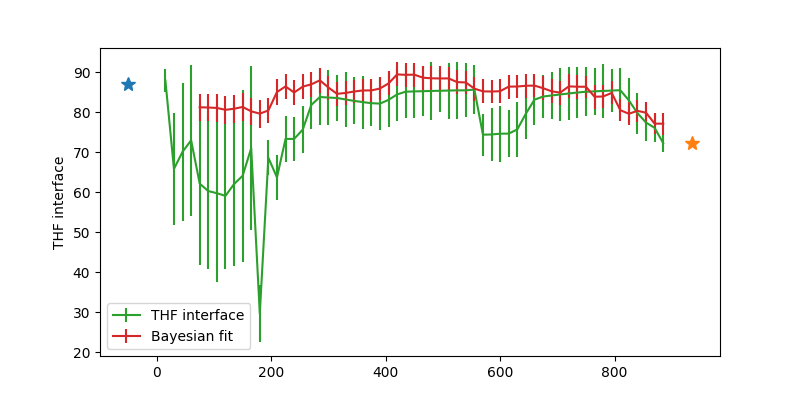

<IPython.core.display.Javascript object>


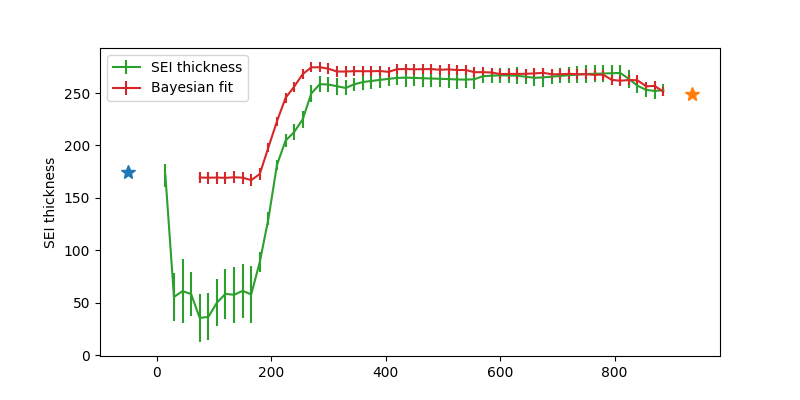

<IPython.core.display.Javascript object>


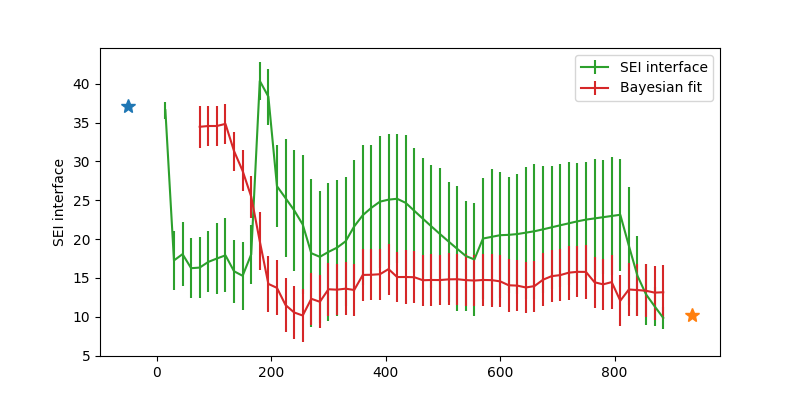

<IPython.core.display.Javascript object>


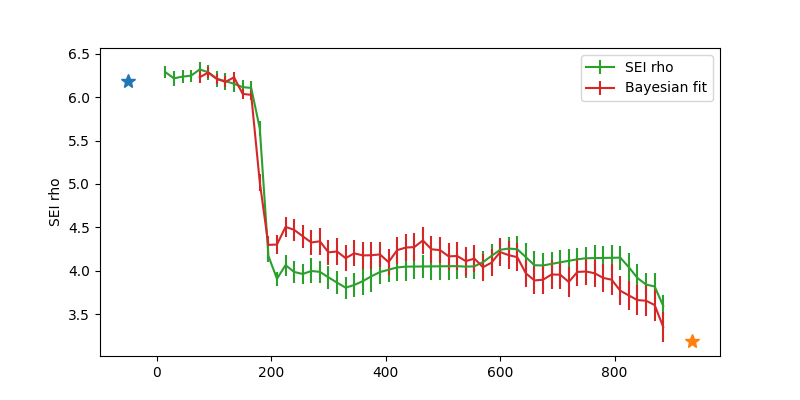

<IPython.core.display.Javascript object>


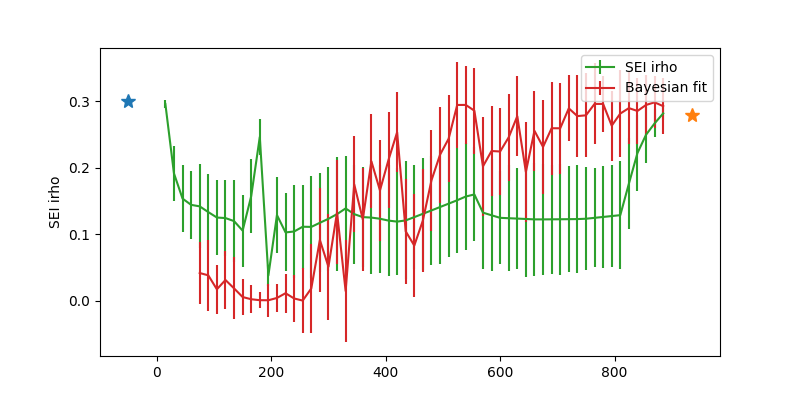

<IPython.core.display.Javascript object>


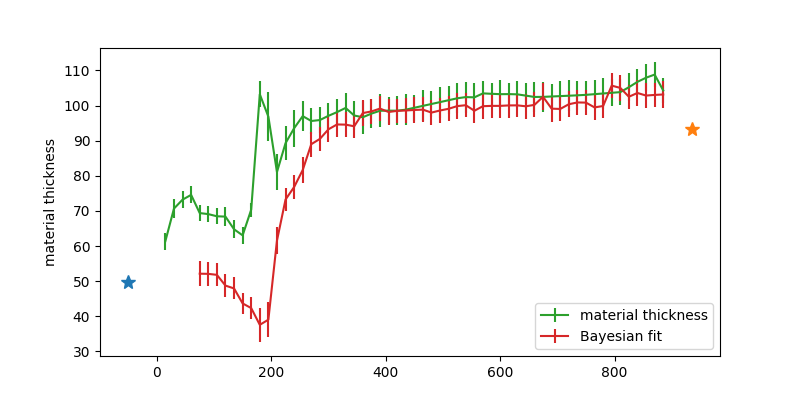

<IPython.core.display.Javascript object>


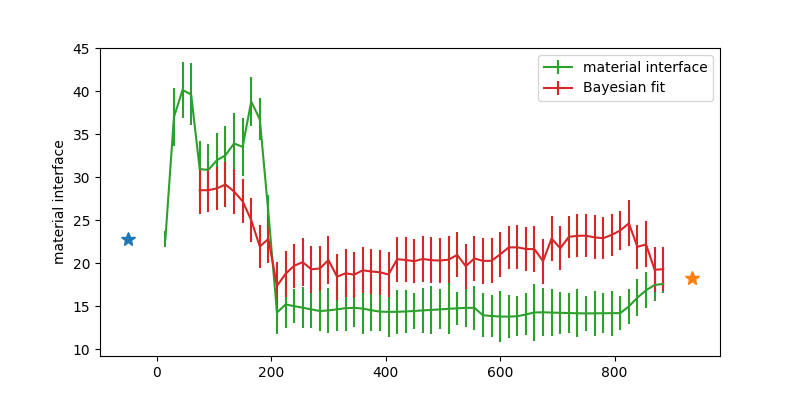

<IPython.core.display.Javascript object>


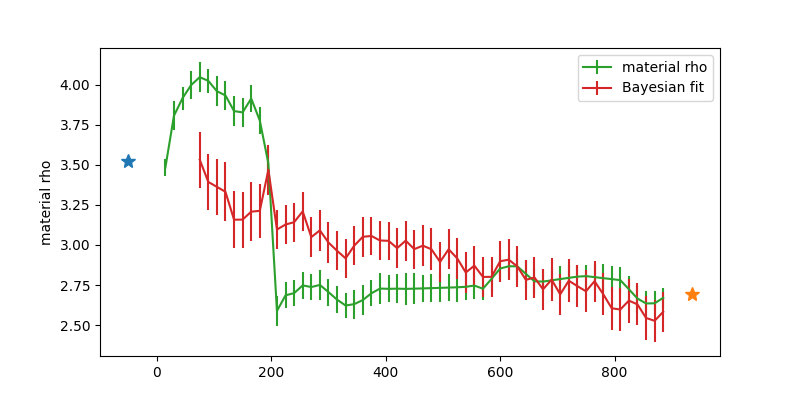

In [242]:
deltas = env.high_array - env.low_array
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0

pars = values.T
errors = errors.T

# Bayesian fit trend
with open( '/Users/m2d/git/vae-sld/data/time-resolved/cell_b/trend-201289.json') as fd:
    bayes_fits = json.load(fd)

if REVERSE:
    t_initial = timestamps[-1]+50
    t_final = -50
    _times = np.flip(timestamps)
else:
    t_final = timestamps[-1]+50
    t_initial = -50
    _times = timestamps

n_times = env.data.shape[0]

print(env.par_labels)
for i in range(pars.shape[0]):
    fig = plt.subplots(dpi=100, figsize=(8, 4))
    #plt.plot(times, pars[i], label=env.par_labels[i])
    plt.plot([t_initial,], [env.parameters[i]], linestyle='', marker='*', markersize=10)
    plt.plot([t_final,], [env.end_parameters[i]], linestyle='', marker='*', markersize=10)
    plt.errorbar(_times, pars[i], yerr=errs[i], label=env.par_labels[i])
    
    plt.errorbar(bayes_fits[0], bayes_fits[1][env.par_labels[i]], yerr=bayes_fits[2][env.par_labels[i]], label='Bayesian fit')
    plt.ylabel(env.par_labels[i])
    plt.legend()

Number of times: 59


<IPython.core.display.Javascript object>


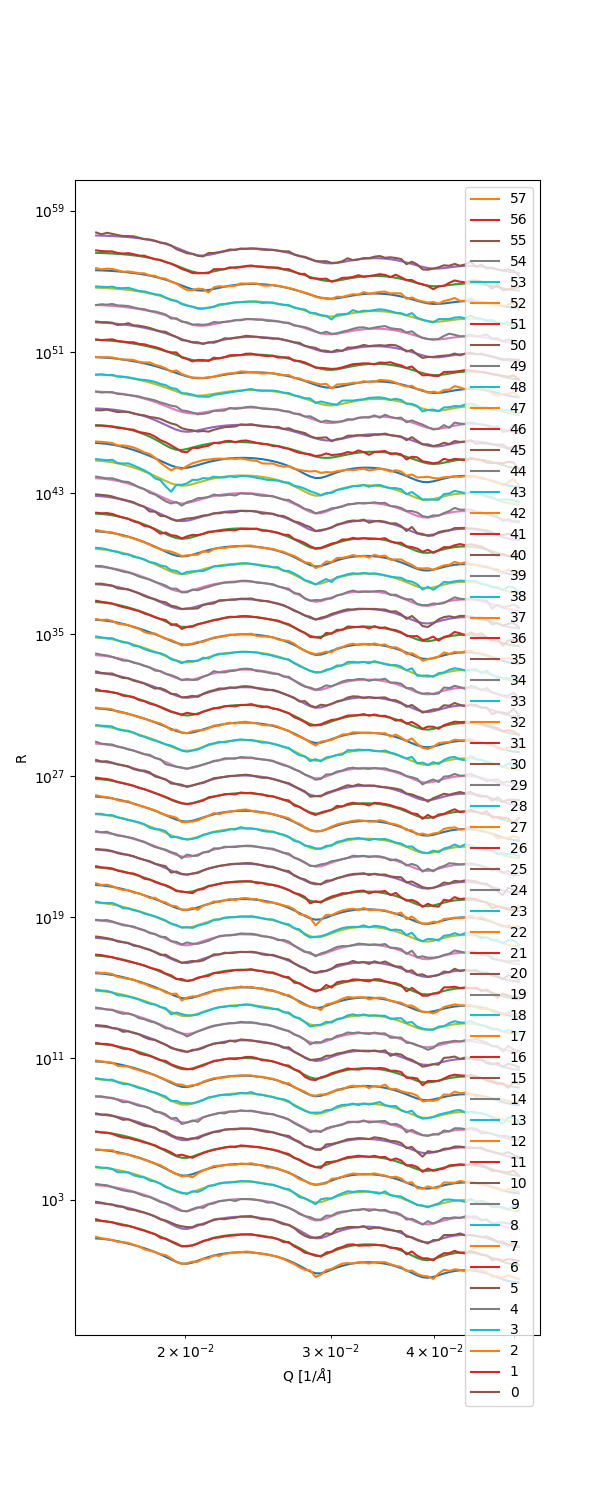

In [229]:
# Evaluate the agent
episode_reward = 0

n_times = env.data.shape[0]
print("Number of times: %s" % n_times)

obs, info = env.reset()

fig = plt.subplots(dpi=100, figsize=(6, 15))
for i in range(1, n_times, 1):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    env.plot(scale=10.**i, newfig=False)


<IPython.core.display.Javascript object>


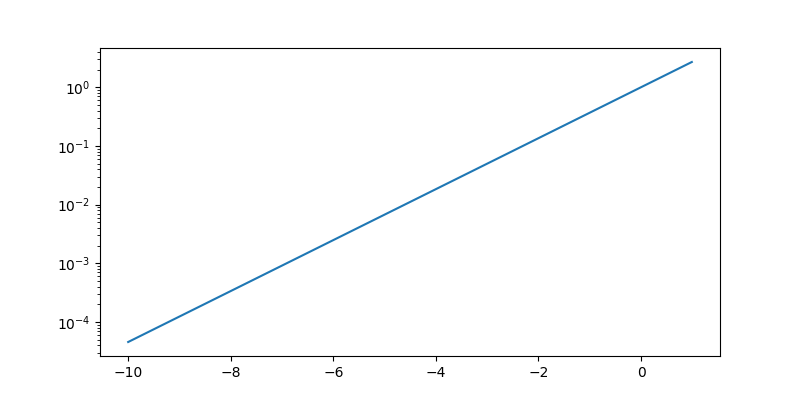

In [16]:
fig, axs = plt.subplots(n_tot,1, dpi=100, figsize=(9,20), sharex=True)
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)

n_times = env.data.shape[0]
n_tot = pars.shape[0]

print(env.par_labels)
for i in range(n_tot):
    ax = plt.subplot(n_tot, 1, i+1)
    
    #plt.plot(times, pars[i], label=env.par_labels[i])
    plt.errorbar(timestamps, pars[i], yerr=errs[i], label=env.par_labels[i])
    
    plt.errorbar(bayes_fits[0], bayes_fits[1][env.par_labels[i]], yerr=bayes_fits[2][env.par_labels[i]], label='Bayesian fit')
    plt.ylabel(env.par_labels[i])
    plt.legend()
    
